In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import Omniglot
from torchvision import transforms

In [6]:
class CNNOmniglot(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc = nn.Sequential(    
            # 1 x 105 x 105
            nn.Conv2d(1, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 64 x 52 x 52
            nn.Conv2d(64, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 64 x 26 x 26
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # 64 x 13 x 13
            nn.Conv2d(128, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),  
            # 64 x 7 x 7
        )

        self.dec = nn.Sequential(
            # 64 x 5 x 5
            nn.ConvTranspose2d(128, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, 3, 2, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, 3, 2, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 1, 4, 2, 1, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.enc(x)
        return self.dec(x)

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ]
)

trainset = Omniglot(root='~/data',  background=True, download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=24)
testset = Omniglot(root='~/data', background=False, download=True, transform=transform)
test_dl = DataLoader(testset, batch_size=64, shuffle=False, num_workers=24)

print(len(train_dl), len(test_dl))

Files already downloaded and verified
Files already downloaded and verified
302 206


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

epochs = 10

model = CNNOmniglot().to(device)

optimizer = Adam(model.parameters(), lr = 0.001)

scheduler = CosineAnnealingLR(optimizer, epochs)

loss_fn = nn.MSELoss()

In [8]:
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img = model(train_img)        
        train_loss = loss_fn(gen_img, train_img)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        tr_total_loss += train_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, _ in tqdm(test_dl):
            valid_img = valid_img.to(device)

            gen_img = model(valid_img)

            valid_loss = loss_fn(gen_img, valid_img)

            va_total_loss += valid_loss.item()

    print(f"Epoch: {epoch} - TrainLoss: {tr_total_loss/len(train_dl)} - ValidLoss: {va_total_loss/len(test_dl)}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [00:03<00:00, 68.08it/s]


Epoch: 0 - TrainLoss: 3.141253562952509 - ValidLoss: 3.071084530608168


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [00:03<00:00, 65.92it/s]


Epoch: 1 - TrainLoss: 3.084304490626253 - ValidLoss: 3.063538922846896


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [00:03<00:00, 67.83it/s]


Epoch: 2 - TrainLoss: 3.0806157604748052 - ValidLoss: 3.0602438831792296


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [00:03<00:00, 68.62it/s]


Epoch: 3 - TrainLoss: 3.0787808934584358 - ValidLoss: 3.0593850242281424


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [00:02<00:00, 69.74it/s]


Epoch: 4 - TrainLoss: 3.077762512971234 - ValidLoss: 3.057755923965602


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [00:03<00:00, 66.34it/s]


Epoch: 5 - TrainLoss: 3.0770174785955065 - ValidLoss: 3.0578738960247596


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [00:02<00:00, 70.09it/s]


Epoch: 6 - TrainLoss: 3.0761833088287456 - ValidLoss: 3.05692881750829


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [00:03<00:00, 68.16it/s]


Epoch: 7 - TrainLoss: 3.0757693762810816 - ValidLoss: 3.0562954921166874


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [00:03<00:00, 62.27it/s]


Epoch: 8 - TrainLoss: 3.0752282324216225 - ValidLoss: 3.0555906064302016


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [00:02<00:00, 69.30it/s]

Epoch: 9 - TrainLoss: 3.074967903806674 - ValidLoss: 3.0549147453122925


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.39it/s]


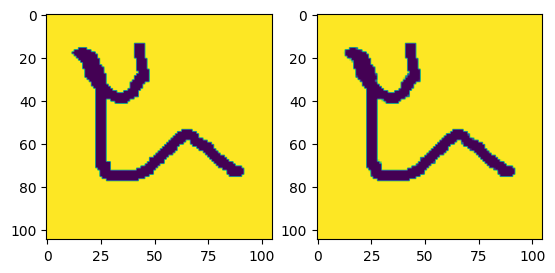

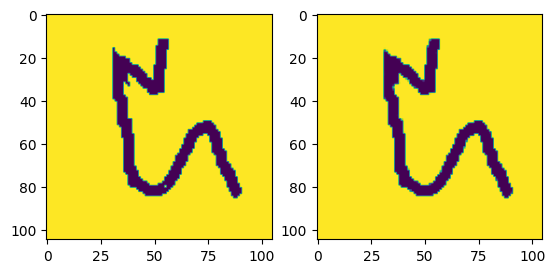

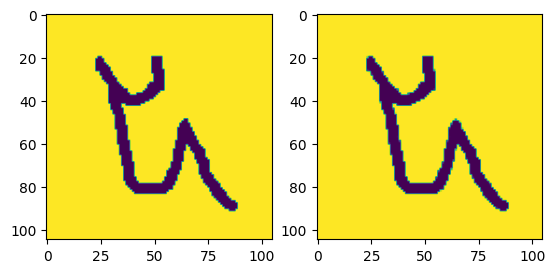

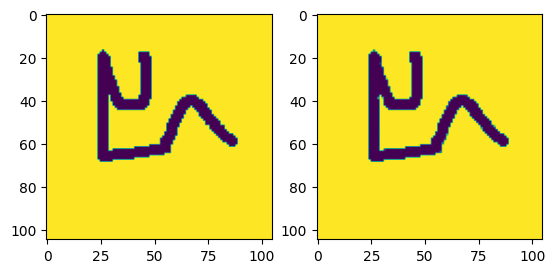

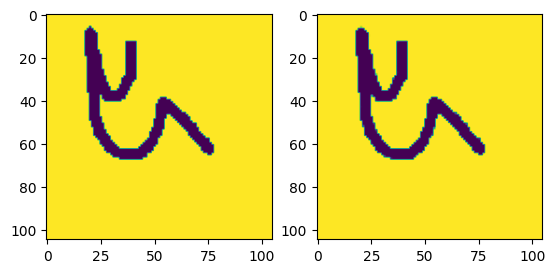

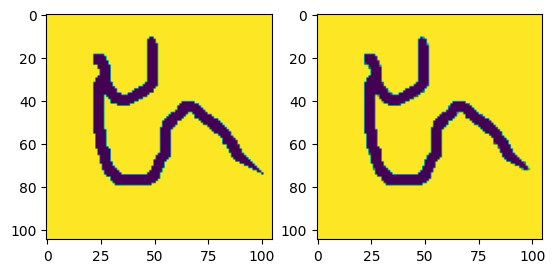

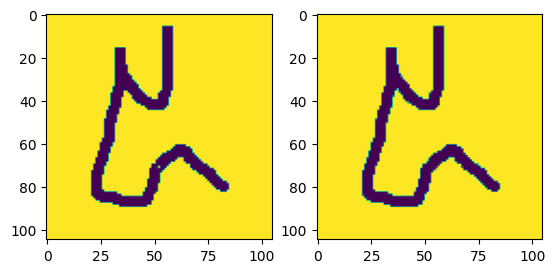

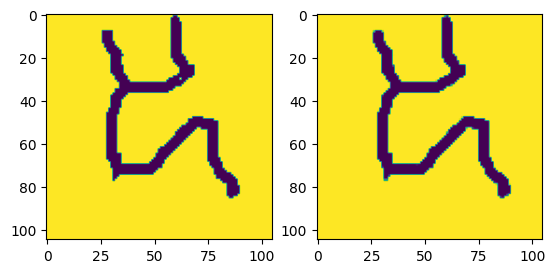

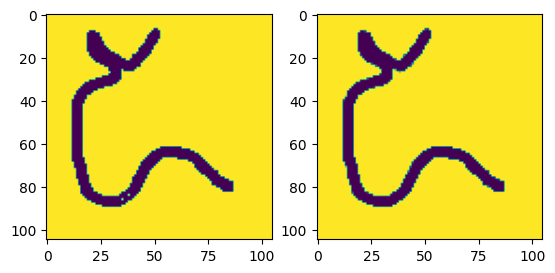

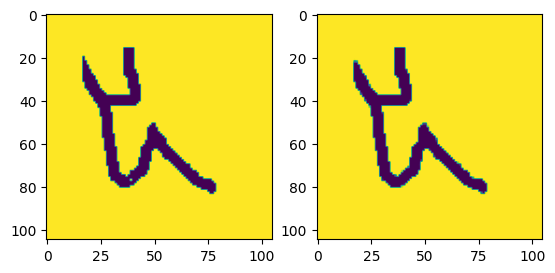

In [9]:
model.eval()
with torch.no_grad():
    for test_case_idx in tqdm(range(10)):
        valid_img, _ = testset[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_img = model(valid_img)        

        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[1].imshow(gen_img[0].cpu().permute(1, -1, 0).numpy())